# House Price Prediction

This notebook is a simple example of how to use a linear regression model to predict house prices given a set of features using a DecisionTreeRegressor. It is an exploratory analysis and the main goal is to show how to use a DecisionTreeRegressor.

In [1]:
import numpy as np
import pandas as pd
from joblib import dump, load
import matplotlib.pyplot as plt

# Model
from sklearn.tree import DecisionTreeRegressor as DTR, plot_tree
from sklearn.model_selection import GridSearchCV, cross_val_score

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Metrics
from sklearn.metrics import r2_score, mean_squared_error

TRAIN_PATH = "./etc/pc2_train.csv"
TEST_PATH = "./etc/pc2_test.csv"
TARGET = "LOGVALUE"
NUMERICAL_COLS = ["BATHS", "BEDRMS", "BUILT", "UNITSF", "ROOMS", "KITCHEN", "FLOORS", "METRO"]
CATEGORICAL_COLS = ["REGION"]
COLS = NUMERICAL_COLS + CATEGORICAL_COLS

PARAMS = {
    "max_depth": np.arange(2, 17, 2),
    "min_samples_split": np.arange(2, 50, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "criterion" : ["squared_error", "friedman_mse", "poisson"]
}

In [2]:
def preprocess(df: pd.DataFrame, target_col: str = None) -> pd.DataFrame:
    # Create a copy of the DataFrame
    df_preprocessed = df.copy()
    
    # Separate the target variable (if specified)
    if target_col:
        y = df_preprocessed[target_col]
        df_preprocessed = df_preprocessed.drop(columns=[target_col])
    else:
        y = None
    
    # Transformers: I use different transformers for numerical and categorical columns.
    numerical_transformer = Pipeline([
        # NOTE: Oddly, either Scaler gives similar performance
        # ('scaler', StandardScaler()),
        ('scaler', MinMaxScaler()),
        ('imputer', SimpleImputer(strategy='mean'))
    ])
    
    categorical_transformer = SimpleImputer(strategy='median')
    
    # Define a simplified ColumnTransformer with a single transformer
    # The steps of this pipeline are as follows:
    # 1. Scaling: Scales values according to the N(0, 1) distribution
    # 2. Impute: Deals with NaNs by imputing them with the mean
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, NUMERICAL_COLS),
            ('cat', categorical_transformer, CATEGORICAL_COLS)
        ])
    
    # Create a pipeline
    pipe = Pipeline([('preprocessor', preprocessor)])
    
    # And fit it
    df_preprocessed[df_preprocessed.columns] = pipe.fit_transform(df_preprocessed[df_preprocessed.columns])
    
    # Fit and transform the data
    X_preprocessed = pipe.fit_transform(df_preprocessed)
    
    # Create a new DataFrame with transformed data and column names
    df_preprocessed = pd.DataFrame(X_preprocessed, columns=df_preprocessed.columns)
    
    return df_preprocessed, y

def train_and_evaluate(model, X_train, y_train, X_test, y_test, params=None):
    if (not params):
        params = PARAMS

    # Use GridSearchCV with the maximum number of CPU cores available
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    # Train the model using GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Best estimator after grid search
    best_model = grid_search.best_estimator_
    
    # Predict using the best model
    y_pred = best_model.predict(X_test)
    
    # Evaluate
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Get cross-validation scores from GridSearchCV results
    cv_scores = grid_search.cv_results_['mean_test_score']
    
    return {
        'cv_scores': cv_scores,
        'r_squared': r_squared,
        'mse': mse,
        'y_pred': y_pred,
        'model': best_model
    }

In [3]:
# Exploratory data analysis
train = pd.read_csv(TRAIN_PATH)
train.describe()

,LOGVALUE,BATHS,BEDRMS,BUILT,UNITSF,LOT,ROOMS,REGION,KITCHEN,FLOORS,LAUNDY,RECRM,METRO,METRO3
count,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.00000,19999.000000,19999.000000,19999.000000
mean,12.054003,1.915196,3.207610,1970.747587,2339.850528,44339.419240,6.571029,2.842342,1.005350,1.931947,0.39192,0.073954,5.664483,1.886644
std,1.093036,0.779724,0.872225,25.543423,1969.763693,114513.834797,1.684882,1.007669,0.072951,1.033308,0.53957,0.271272,2.464029,1.010843
min,0.000000,0.000000,0.000000,1919.000000,99.000000,200.000000,2.000000,1.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000
25%,11.512925,1.000000,3.000000,1950.000000,1400.000000,6000.000000,5.000000,2.000000,1.000000,1.000000,0.00000,0.000000,7.000000,2.000000
50%,12.100712,2.000000,3.000000,1975.000000,2000.000000,11000.000000,6.000000,3.000000,1.000000,2.000000,0.00000,0.000000,7.000000,2.000000
75%,12.611538,2.000000,4.000000,1990.000000,2487.000000,43925.933653,8.000000,4.000000,1.000000,2.000000,1.00000,0.000000,7.000000,2.000000
max,15.476535,10.000000,8.000000,2011.000000,20159.000000,933185.000000,15.000000,4.000000,2.000000,21.000000,5.00000,3.000000,7.000000,9.000000


In [4]:
# Preprocess
train = train[COLS + [TARGET]]
X, y = preprocess(train, TARGET)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1203)
X_train.head()

,BATHS,BEDRMS,BUILT,UNITSF,ROOMS,KITCHEN,FLOORS,METRO,REGION
18220,0.3,0.500,0.608696,0.094766,0.384615,0.0,0.05,1.0,4.0
18371,0.1,0.250,0.000000,0.057478,0.153846,0.0,0.05,1.0,1.0
10577,0.4,0.625,0.826087,0.643071,0.923077,0.0,0.10,1.0,2.0
13828,0.3,0.500,0.228261,0.144616,0.538462,0.0,0.05,0.0,3.0
18526,0.3,0.375,0.989130,0.119691,0.307692,0.0,0.05,1.0,3.0


In [5]:
def f(i):
    '''Master method to train and evaluate models, display the results and plot graphs.'''
    results = train_and_evaluate(DTR(), X_train, y_train, X_test, y_test)

    # Extract the results
    cv_scores = results['cv_scores']
    r_squared = results['r_squared']
    mse = results['mse']
    best_model = results['model']

    # Print or use the extracted results as needed
    print(f'Cross-Validation Scores: {cv_scores}')
    print(f'R-squared: {r_squared}')
    print(f'Mean Squared Error: {mse}')
    print(f'Best Model: {best_model}')
    
    model_name = f"dtr{i}"
    
    # Save the model
    print(f"Saving model {i}...")
    dump(best_model, filename=model_name)
    
    # Save feature importances
    print("Plotting feature importances...")
    # Sort columns based on feature importances
    sorted_cols = sorted(zip(COLS, best_model.feature_importances_), key=lambda x: x[1])
    print(sorted_cols)

    # Unzip the sorted pairs into two lists
    labels, values = zip(*sorted_cols)
    
    plt.barh(labels, values)
    # plt.barh(COLS, best_model.feature_importances_)
    # plt.show()
    plt.savefig(model_name + "_fi.png")
    
    # EXTRA: Save a picture of the tree
    print("Saving a picture of the tree...")
    fig = plt.figure(figsize=(25,20))
    _ = plot_tree(best_model, feature_names=X_train.columns, filled=True)
    fig.savefig(model_name + "_dt.png")
    
    return results

Cross-Validation Scores: [-1.01338733 -1.01338733 -1.01338733 ... -0.89401764 -0.89302232
 -0.89131195]
R-squared: 0.3107897023114099
Mean Squared Error: 0.7515350733499296
Best Model: DecisionTreeRegressor(max_depth=8, min_samples_leaf=19, min_samples_split=48)
Saving model 5...
Plotting feature importances...
[('KITCHEN', 0.0), ('BEDRMS', 0.004550232701753905), ('METRO', 0.011183200676627585), ('BATHS', 0.05866352664813431), ('FLOORS', 0.0707106499746862), ('BUILT', 0.09434332360749391), ('UNITSF', 0.21504811564748552), ('REGION', 0.26543562587754266), ('ROOMS', 0.28006532486627594)]
Saving a picture of the tree...


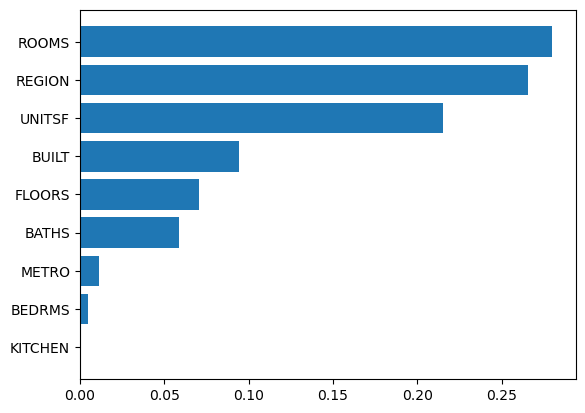

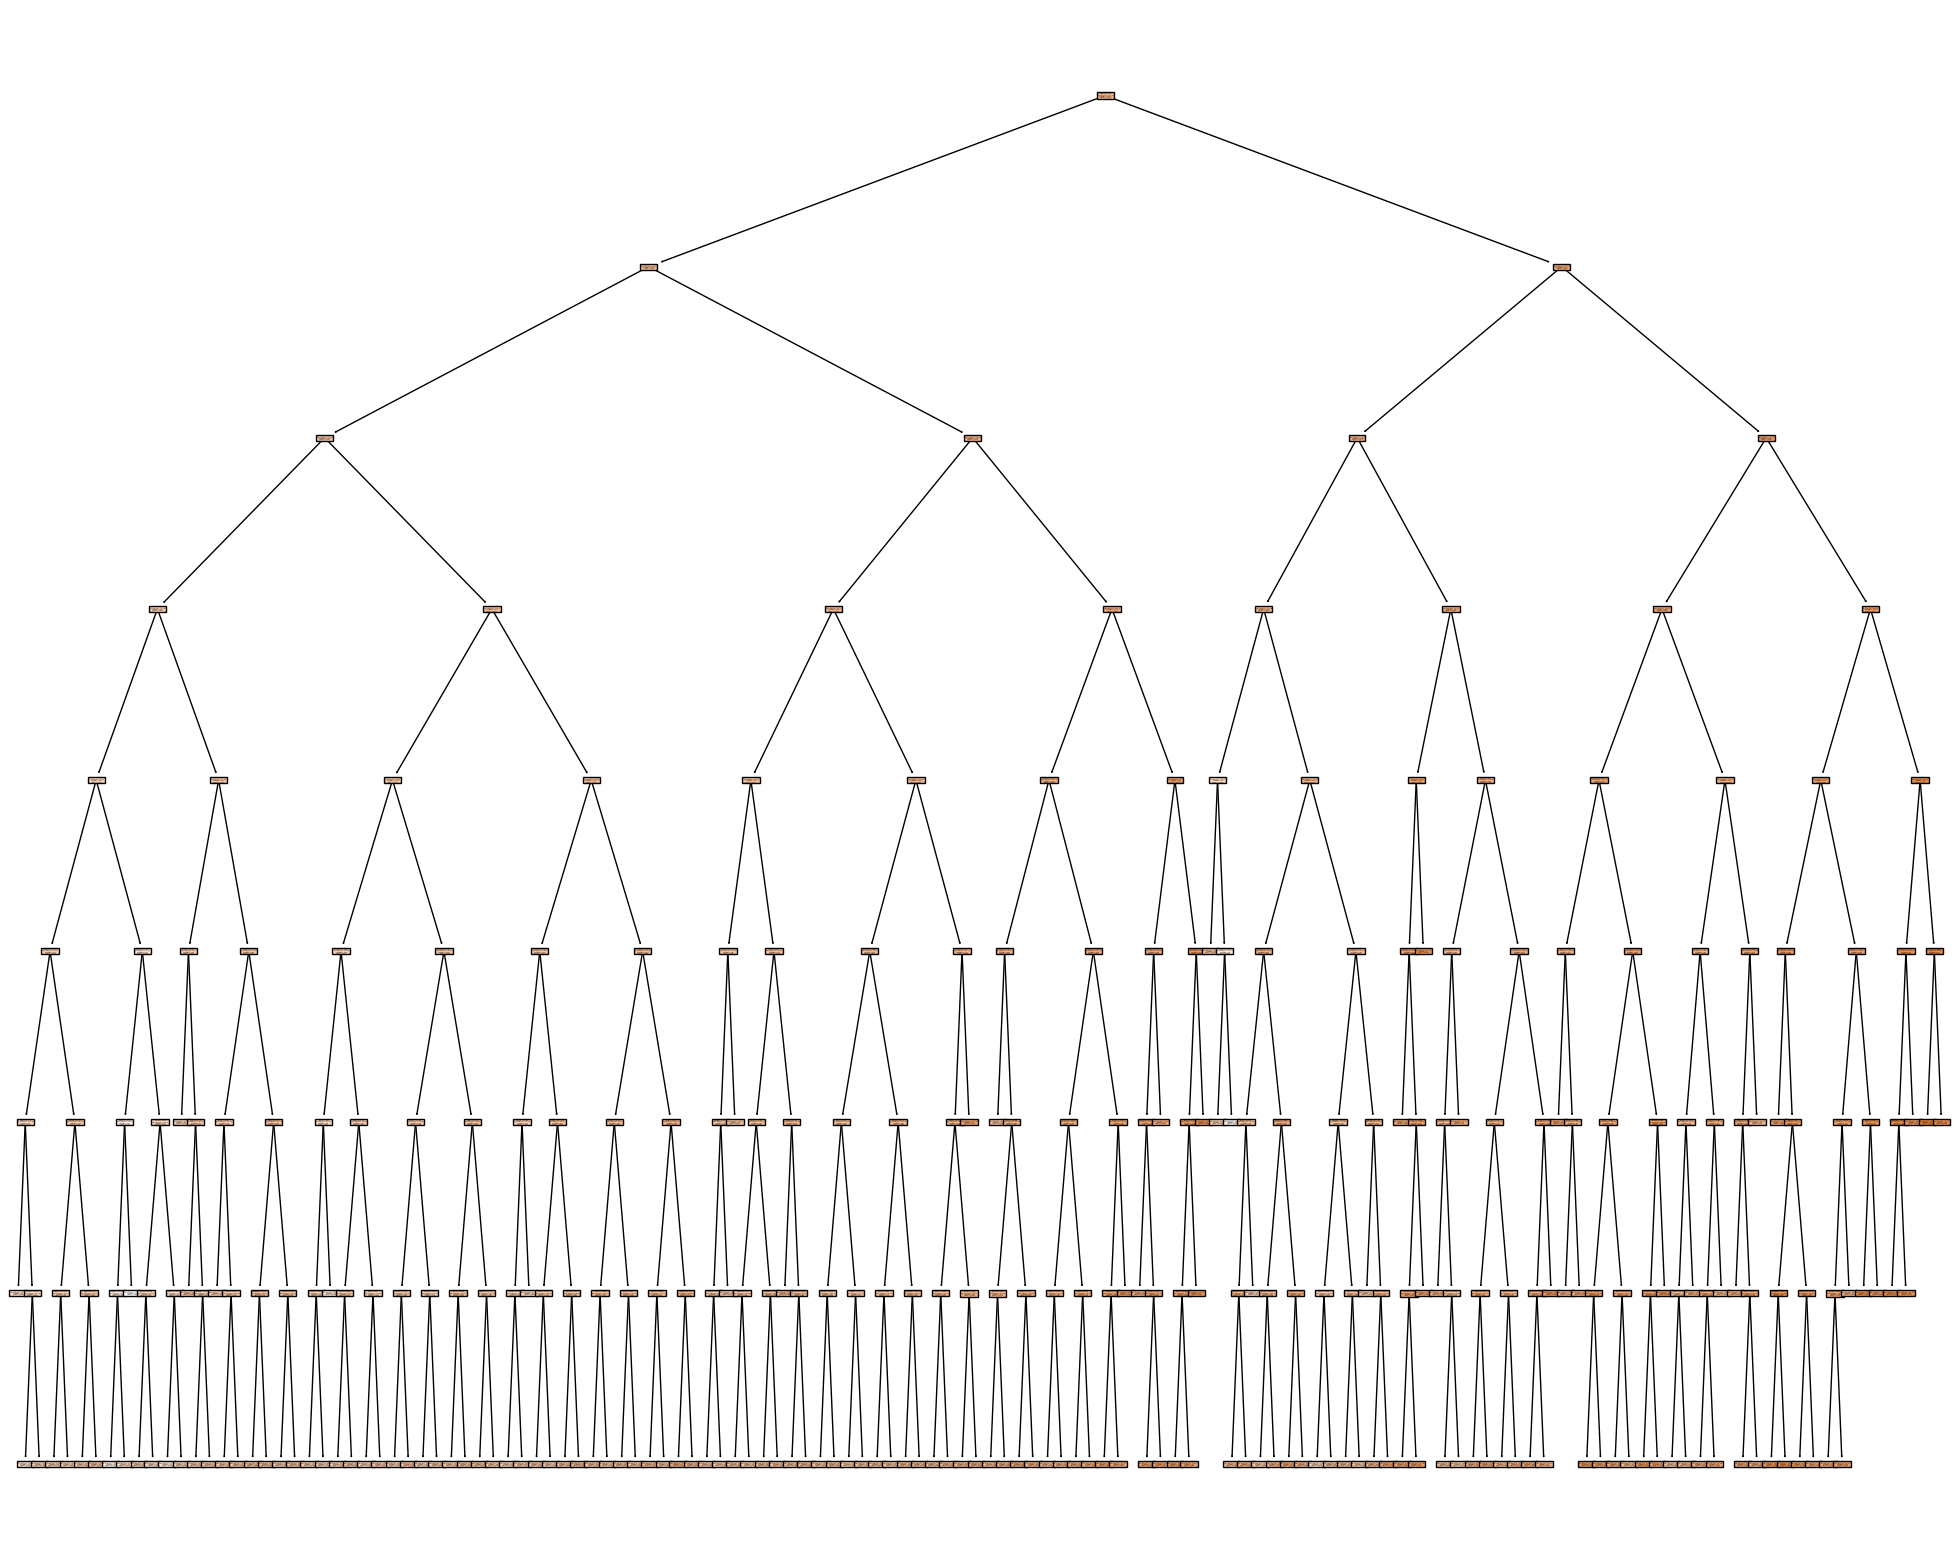

In [6]:
results = f(5)

In [7]:
def get_test_preds(model):
    # Load test data
    test = pd.read_csv(TEST_PATH)
    test.columns = [col.upper() for col in test.columns]
    
    # Preprocess test data
    test_preprocessed, _ = preprocess(test[COLS])
    
    # print(test_preprocessed.head())
    
    # Get predictions
    preds = model.predict(test_preprocessed)
    
    # And save them
    filename = "test_preds.csv"
    np.savetxt(filename, preds, delimiter=",", header="LOGVALUE")

    # Sanity check
    d = pd.read_csv(filename)
    print(d.shape)
    print(d.head())
          
best_model = load("dtr4")
get_test_preds(best_model)

(10000, 1)
   # LOGVALUE
0   12.503981
1   12.353177
2   12.906600
3   11.927530
4   12.503981
